<a href="https://colab.research.google.com/github/bposantos/NMR_spectra_assignment/blob/main/manipulacao_peak_list.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peak list

## Bibliotecas

In [205]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from collections import defaultdict

## Espectros

### 1H-1H TOCSY

In [206]:
df = pd.read_csv('teste.peaks', delim_whitespace=True, comment='#', header=None)
df.set_index(0, inplace=True)

<ipython-input-206-e27a1306ef3f>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('teste.peaks', delim_whitespace=True, comment='#', header=None)


### 13C-1H HSQC

In [207]:
df_hsqc = pd.read_csv('teste_c_h.peaks', delim_whitespace=True, comment='#', header=None)
df_hsqc.set_index(0, inplace=True)
df_hsqc.head()

<ipython-input-207-7b2b157c491d>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_hsqc = pd.read_csv('teste_c_h.peaks', delim_whitespace=True, comment='#', header=None)


,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,
1,46.587,3.946,1,T,-1.067000e+10,0.0,a,0,0,0,0
2,46.338,3.789,1,T,-6.645000e+09,0.0,a,0,0,0,0
3,46.439,3.960,1,T,-7.849000e+09,0.0,a,0,0,0,0
4,46.345,3.904,1,T,-7.237000e+09,0.0,a,0,0,0,0
5,58.047,4.066,1,T,9.754000e+09,0.0,a,0,0,0,0


### 1H-1H NOESY

In [208]:
df_noesy = pd.read_csv('teste_h_h.peaks', delim_whitespace=True, comment='#', header=None)
df_noesy.set_index(0, inplace=True)
df_noesy.head()

<ipython-input-208-538e090b5674>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_noesy = pd.read_csv('teste_h_h.peaks', delim_whitespace=True, comment='#', header=None)


,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,
1,8.109,7.982,1,T,3.007000e+10,0.0,a,0,0,0,0
2,8.171,7.984,1,T,2.468000e+10,0.0,a,0,0,0,0
3,7.984,8.171,1,T,2.258000e+10,0.0,a,0,0,0,0
4,7.982,8.110,1,T,2.506000e+10,0.0,a,0,0,0,0
5,8.173,7.904,1,T,2.988000e+10,0.0,a,0,0,0,0


## Pré-processamento

#### Seleção inicial de dados

In [209]:
# Renomear colunas e converter para float
df.rename(columns={1:'F1',2:'F2',3:'Position',4:'Chain',5:'Volume'}, inplace=True)
df['F1'] = pd.to_numeric(df['F1'], errors='coerce')
df['F2'] = pd.to_numeric(df['F2'], errors='coerce')
df_hsqc.rename(columns={1:'F1',2:'F2',3:'Position',4:'Chain',5:'Volume'}, inplace=True)
df_hsqc['F1'] = pd.to_numeric(df_hsqc['F1'], errors='coerce')
df_hsqc['F2'] = pd.to_numeric(df_hsqc['F2'], errors='coerce')
df_noesy.rename(columns={1:'F1',2:'F2',3:'Position',4:'Chain',5:'Volume'}, inplace=True)
df_noesy['F1'] = pd.to_numeric(df_noesy['F1'], errors='coerce')
df_noesy['F2'] = pd.to_numeric(df_noesy['F2'], errors='coerce')

In [210]:
# Ordenar coluna F2
df.sort_values(by='F2', ascending=False, inplace=True)

# Usar os sinais amidicos na dimensao F2 e os sinais da cadeia lateral na dimensao F1
#df_filtrado = df[(df['F2'] >= 7.711) & (df['F1'] < 5.5)]

# Usar os sinais alfa na dimensao F2 e as cadeias laterais na dimensao F1
df_filtrado = df[(df['F2'] > 3.8) & (df['F2'] <= 5) & (df['F1'] < 5)]

df_complementar = df[~((df['F2'] > 3.8) & (df['F2'] <= 5) & (df['F1'] < 5))]

#### Identificar os sinais dos anéis aromáticos e outros hidrogênios amídicos

In [211]:
# Pegar sinais amidicos na dimensao F2 e cadeia lateral na dimensao F1 do TOCSY
df_aro = df[(df['F2'] < 7.711) & (df['F2'] > 5.5)]

# Encontrar a conexão dos sistemas de spin com os aneis
# Usar somente os sinais de aneis aromáticos do NOESY que são presentes no TOCSY
df_aro_n = df_noesy[(df_noesy['F2'] < 8) & (df_noesy['F2'] > 5.5)]
df_aro_n = df_aro_n[df_aro_n['F2'].isin(df_aro['F2'])]

In [212]:
#Idenficar quais sistemas de spin do TOCSY fazem correspondência com os sinais aromático

# Get F1 values from both dataframes
values_filtrado = df_filtrado['F1'].values.reshape(-1, 1)  # Shape (n, 1)
values_aro_n = df_aro_n['F1'].values.reshape(1, -1)        # Shape (1, m)

# Compute absolute differences between all pairs
differences = np.abs(values_filtrado - values_aro_n)  # Shape (n, m)

# Check which differences are within tolerance
mask = np.any(differences <= 0.06, axis=1)

# Apply the mask to filter df_filtrado
df_rsn_aro = df_filtrado[mask] #TOCSY

# Seleção dos sinais de alfa
df_rsn_aro = df_rsn_aro[(df_rsn_aro['F1'] < 5.5) & (df_rsn_aro['F1'] > 3)]
df_rsn_aro

,F1,F2,Position,Chain,Volume,6,7,8,9,10,11
0,,,,,,,,,,,
126,3.123,4.419,1,T,5.847000e+09,0.0,a,0,0,0,0
23,4.294,4.078,1,T,2.114000e+10,0.0,a,0,0,0,0
21,4.309,3.942,1,T,4.277000e+10,0.0,a,0,0,0,0


## Identificação dos Sistemas de Spins
 Aprendizado de máquina - DBSCAN

#### Agrupamento inicial
Dados: DF filtrado

In [213]:
X = df_filtrado['F2'].values.reshape(-1, 1)  # Transforma em array 2D para o DBSCAN

# Configuracao DBSCAN:
# - eps=0.01 (diferença máxima para estar no mesmo grupo)
# - min_samples=1 (cada ponto forma seu próprio grupo se isolado)
dbscan = DBSCAN(eps=0.004, min_samples=1).fit(X)

# Adiciona os rótulos dos grupos ao DataFrame
df_filtrado.loc[:,'Classe'] = dbscan.labels_

# Agrupa por 'Classe' e cria as entradas do dicionário
dict_classes = {}
for classe, group in df_filtrado.groupby('Classe'):
    dict_classes[classe] = [f"{row['F1']}-{row['F2']}" for _, row in group.iterrows()]

# Resultado
for i in dict_classes:
  print(f"Classe {i}: {dict_classes[i]}")

Classe 0: ['3.123-4.419']
Classe 1: ['3.27-4.35']
Classe 2: ['1.195-4.313', '3.946-4.31']
Classe 3: ['1.267-4.296']
Classe 4: ['4.078-4.291', '3.891-4.29']
Classe 5: ['1.623-4.133', '1.842-4.132', '1.873-4.132', '0.865-4.13', '0.834-4.129', '1.354-4.126']
Classe 6: ['1.269-4.08', '4.294-4.078']
Classe 7: ['1.642-4.07', '1.692-4.07', '0.899-4.069', '1.597-4.069', '0.852-4.068']
Classe 8: ['1.409-4.017', '1.635-4.017', '1.496-4.017', '1.853-4.016']
Classe 9: ['2.93-4.009']
Classe 10: ['1.796-3.977', '1.768-3.977', '0.895-3.977', '1.574-3.977', '0.823-3.977']
Classe 11: ['1.193-3.948']
Classe 12: ['4.309-3.942']
Classe 13: ['0.993-3.937', '1.867-3.936', '1.349-3.935', '0.81-3.935', '0.797-3.935']
Classe 14: ['4.29-3.889']


<ipython-input-213-d1901b8fef1b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.loc[:,'Classe'] = dbscan.labels_


#### Adição dos dados relativos aos aneis aromaticos

In [214]:
# Criar um dicionário auxiliar: F2_amidico -> Classe
f2_to_classe = df_filtrado.set_index('F2')['Classe'].to_dict()

# Para cada sinal em df_aro_n (NOESY), encontrar a classe correspondente
for idx, row in df_aro_n.iterrows():
    F1_noesy = row['F1']  # Sinal amidico no NOESY (F1 < 5)
    F2_noesy = row['F2']  # Sinal aromático no NOESY (6-7.5)

    # Encontrar a classe do F1_noesy (com tolerância)
    for f2_amidico, classe in f2_to_classe.items():
        if abs(F1_noesy - f2_amidico) <= 0.005:
            # Adicionar o par aromático (df_aro) ao dict_classes
            dict_classes[classe].append(f"{row['F1']}-{F2_noesy}")
            break

In [215]:

'''
# Criar um dicionário que mapeia F2_aromático (NOESY) -> F1_amidico (NOESY) -> Classe (TOCSY)
classe_map = {}
for idx, row in df_aro_n.iterrows():
    F1_noesy = row['F1']  # Sinal amidico no NOESY (F1 < 5)
    F2_noesy = row['F2']  # Sinal aromático no NOESY (6-7.5)

    # Encontrar a classe do F1_noesy em df_filtrado (com tolerância)
    mask = np.isclose(df_filtrado['F2'], F1_noesy, atol=0.005)
    if mask.any():
        classe = df_filtrado.loc[mask, 'Classe'].values[0]
        classe_map[F2_noesy] = classe

# Filtrar df_aro para pegar apenas sinais que estão em classe_map (com tolerância)
df_aro['Classe'] = None
for F2_aro in classe_map.keys():
    mask = np.isclose(df_aro['F2'], F2_aro, atol=0.005)
    df_aro.loc[mask, 'Classe'] = classe_map[F2_aro]

# Adicionar ao df_filtrado (apenas linhas com classe definida)
df_aro_to_add = df_aro.dropna(subset=['Classe'])
df_filtrado = pd.concat([df_filtrado, df_aro_to_add], ignore_index=True)
'''

"\n# Criar um dicionário que mapeia F2_aromático (NOESY) -> F1_amidico (NOESY) -> Classe (TOCSY)\nclasse_map = {}\nfor idx, row in df_aro_n.iterrows():\n    F1_noesy = row['F1']  # Sinal amidico no NOESY (F1 < 5)\n    F2_noesy = row['F2']  # Sinal aromático no NOESY (6-7.5)\n    \n    # Encontrar a classe do F1_noesy em df_filtrado (com tolerância)\n    mask = np.isclose(df_filtrado['F2'], F1_noesy, atol=0.005)\n    if mask.any():\n        classe = df_filtrado.loc[mask, 'Classe'].values[0]\n        classe_map[F2_noesy] = classe\n        \n# Filtrar df_aro para pegar apenas sinais que estão em classe_map (com tolerância)\ndf_aro['Classe'] = None\nfor F2_aro in classe_map.keys():\n    mask = np.isclose(df_aro['F2'], F2_aro, atol=0.005)\n    df_aro.loc[mask, 'Classe'] = classe_map[F2_aro]\n\n# Adicionar ao df_filtrado (apenas linhas com classe definida)\ndf_aro_to_add = df_aro.dropna(subset=['Classe'])\ndf_filtrado = pd.concat([df_filtrado, df_aro_to_add], ignore_index=True)\n"

#### Atribuição das outras correlações

In [216]:
# 1. Obter linhas remanescentes (não presentes em df_filtrado)
#df_remanescente = df[~df.index.isin(df_filtrado.index)].copy()
df_remanescente = df_complementar.copy()

# 2. Dicionário para armazenar os índices adicionados e suas classes
relatorio_inclusao = defaultdict(list)  # Formato: {índice: (classe, valor_adicionado)}

#df_remanescente = df_remanescente[df_remanescente['F2'] <= 5.5]

# 3. Para cada linha em df_filtrado, buscar correspondências em df_remanescente

for _, row_filtrado in df_filtrado.iterrows():
    f1_ref = row_filtrado['F1']  # Valor de referência (F1 do df_filtrado)
    classe = row_filtrado['Classe']  # Classe correspondente

    # Encontrar linhas remanescentes onde F2 ≈ F1_ref (tolerância 0.002)
    mask = np.isclose(df_remanescente['F2'], f1_ref, atol=0.002)
    correspondentes = df_remanescente[mask]

    # Adicionar ao dicionário principal e registrar no relatório
    for idx, row_corresp in correspondentes.iterrows():
        valor = f"{row_corresp['F1']}-{row_corresp['F2']}"
        dict_classes[classe].append(valor)
        relatorio_inclusao[idx].append((classe, valor))  # Registra no relatório

# 4. Exibir resultados
print("Dicionário atualizado (dict_classes):")
for i in dict_classes:
  print(f"Class {i}: {dict_classes[i]}")

#print("\nRelatório de inclusão (índices adicionados):")
#for idx, dados in relatorio_inclusao.items():
#    print(f"Índice {idx} → Adicionado em: {dados}")

Dicionário atualizado (dict_classes):
Class 0: ['3.123-4.419', '4.423-7.252', '4.42-3.123']
Class 1: ['3.27-4.35', '4.352-7.348']
Class 2: ['1.195-4.313', '3.946-4.31', '4.312-1.194', '3.948-1.193']
Class 3: ['1.267-4.296', '4.08-1.268', '4.296-1.268']
Class 4: ['4.078-4.291', '3.891-4.29', '8.052-4.079']
Class 5: ['1.623-4.133', '1.842-4.132', '1.873-4.132', '0.865-4.13', '0.834-4.129', '1.354-4.126', '4.127-1.354', '7.828-1.352']
Class 6: ['1.269-4.08', '4.294-4.078', '4.08-1.268', '4.296-1.268']
Class 7: ['1.642-4.07', '1.692-4.07', '0.899-4.069', '1.597-4.069', '0.852-4.068', '0.852-1.643', '0.898-1.642', '0.853-1.691', '0.899-1.691']
Class 8: ['1.409-4.017', '1.635-4.017', '1.496-4.017', '1.853-4.016', '2.929-1.41', '1.634-1.41', '4.008-1.409', '1.853-1.409', '1.496-1.409', '4.01-1.635', '1.41-1.635', '2.929-1.635', '1.854-1.635', '1.497-1.634', '2.929-1.497', '1.853-1.497', '1.634-1.497', '4.009-1.497', '1.407-1.497', '1.496-1.853', '1.637-1.853', '4.01-1.853', '2.928-1.853', '1.

#### Adição dos Sinais de Carbono

In [217]:
# 2. Dicionário para armazenar os índices adicionados e suas classes
relatorio_inclusao_c = defaultdict(list)  # Formato: {índice: (classe, valor_adicionado)}

# 3. Para cada linha em df_filtrado, buscar correspondências em df_hsqc
for _, row_filtrado in df_filtrado.iterrows():
    f1_ref = row_filtrado['F1']  # Valor de referência (F1 do df_filtrado)
    classe = row_filtrado['Classe']  # Classe correspondente

    # Encontrar linhas remanescentes onde F2 ≈ F1_ref (tolerância 0.002)
    mask = np.isclose(df_hsqc['F2'], f1_ref, atol=0.007)
    correspondentes = df_hsqc[mask]

    # Adicionar ao dicionário principal e registrar no relatório
    for idx, row_corresp in correspondentes.iterrows():
        valor = f"{row_corresp['F1']}-{row_corresp['F2']}"
        dict_classes[classe].append(valor)
        relatorio_inclusao_c[idx].append((classe, valor))  # Registra no relatório

# 4. Exibir resultados
print("Dicionário atualizado (dict_classes):")
for i in dict_classes:
  print(f"Class {i}: {dict_classes[i]}")

print("\nRelatório de inclusão (índices adicionados):")
for idx, dados in relatorio_inclusao_c.items():
    print(f"Índice {idx} → Adicionado em: {dados}")


Dicionário atualizado (dict_classes):
Class 0: ['3.123-4.419', '4.423-7.252', '4.42-3.123', '39.593-3.126']
Class 1: ['3.27-4.35', '4.352-7.348', '39.373-3.268']
Class 2: ['1.195-4.313', '3.946-4.31', '4.312-1.194', '3.948-1.193', '21.76-1.195', '46.587-3.946']
Class 3: ['1.267-4.296', '4.08-1.268', '4.296-1.268', '21.888-1.268']
Class 4: ['4.078-4.291', '3.891-4.29', '8.052-4.079', '64.616-4.076', '63.242-3.888']
Class 5: ['1.623-4.133', '1.842-4.132', '1.873-4.132', '0.865-4.13', '0.834-4.129', '1.354-4.126', '4.127-1.354', '7.828-1.352', '41.884-1.62', '31.923-1.848', '41.97-1.873', '25.122-0.858', '25.423-0.863', '23.68-0.827', '23.349-0.835', '19.601-1.347', '27.729-1.35']
Class 6: ['1.269-4.08', '4.294-4.078', '4.08-1.268', '4.296-1.268', '21.888-1.268', '69.096-4.295', '60.408-4.291']
Class 7: ['1.642-4.07', '1.692-4.07', '0.899-4.069', '1.597-4.069', '0.852-4.068', '0.852-1.643', '0.898-1.642', '0.853-1.691', '0.899-1.691', '41.989-1.643', '42.043-1.691', '24.791-0.899', '24.56

In [218]:
indices_totais = set(df_hsqc.index.tolist())
indices_adicionados = set(relatorio_inclusao_c.keys())
indices_nao_adicionados = indices_totais - indices_adicionados
relatorio_nao_adicionados = {
    idx: f"{df_hsqc.loc[idx, 'F1']}-{df_hsqc.loc[idx, 'F2']}"
    for idx in indices_nao_adicionados
}

# Exibir resultados
print("\nÍndices NÃO adicionados e seus valores:")
for idx, valor in relatorio_nao_adicionados.items():
    print(f"Índice {idx}: {valor}")


Índices NÃO adicionados e seus valores:
Índice 2: 46.338-3.789
Índice 3: 46.439-3.96
Índice 4: 46.345-3.904
Índice 5: 58.047-4.066
Índice 37: 131.625-7.253
Índice 38: 131.375-7.214
Índice 40: 57.868-4.354
Índice 41: 52.58-4.127
Índice 11: 58.167-3.975
Índice 44: 27.696-0.981
Índice 46: 66.151-3.937
Índice 17: 58.971-4.009
Índice 49: 132.341-7.348
Índice 50: 131.692-7.299
Índice 23: 62.539-3.935
Índice 28: 57.998-4.135
Índice 31: 26.805-1.833


## Transformação de números próximos em um único valor para a identificação do resíduo

In [219]:
'''

from collections import defaultdict
import numpy as np

def agrupar_valores_proximos(valores, tolerancia=0.002):
    if not valores:
        return []

    # Extrai F1 e F2 separadamente
    f1_list = [float(v.split('-')[0]) for v in valores]
    f2_list = [float(v.split('-')[1]) for v in valores]

    # Agrupa F1 próximos
    grupos_f1 = []
    usado_f1 = set()
    for i, f1 in enumerate(f1_list):
        if i not in usado_f1:
            grupo = [i]
            for j in range(i+1, len(f1_list)):
                if np.isclose(f1, f1_list[j], atol=tolerancia):
                    grupo.append(j)
                    usado_f1.add(j)
            grupos_f1.append(grupo)

    # Agrupa F2 próximos
    grupos_f2 = []
    usado_f2 = set()
    for i, f2 in enumerate(f2_list):
        if i not in usado_f2:
            grupo = [i]
            for j in range(i+1, len(f2_list)):
                if np.isclose(f2, f2_list[j], atol=tolerancia):
                    grupo.append(j)
                    usado_f2.add(j)
            grupos_f2.append(grupo)

    # Substitui por representantes (primeiro do grupo)
    novos_valores = []
    for v in valores:
        novos_valores.append(v)  # Inicialmente mantém o original

    for grupo in grupos_f1:
        representante_f1 = f1_list[grupo[0]]
        for idx in grupo:
            partes = novos_valores[idx].split('-')
            novos_valores[idx] = f"{representante_f1}-{partes[1]}"

    for grupo in grupos_f2:
        representante_f2 = f2_list[grupo[0]]
        for idx in grupo:
            partes = novos_valores[idx].split('-')
            novos_valores[idx] = f"{partes[0]}-{representante_f2}"

    return novos_valores

'''

'\n\nfrom collections import defaultdict\nimport numpy as np\n\ndef agrupar_valores_proximos(valores, tolerancia=0.002):\n    if not valores:\n        return []\n\n    # Extrai F1 e F2 separadamente\n    f1_list = [float(v.split(\'-\')[0]) for v in valores]\n    f2_list = [float(v.split(\'-\')[1]) for v in valores]\n\n    # Agrupa F1 próximos\n    grupos_f1 = []\n    usado_f1 = set()\n    for i, f1 in enumerate(f1_list):\n        if i not in usado_f1:\n            grupo = [i]\n            for j in range(i+1, len(f1_list)):\n                if np.isclose(f1, f1_list[j], atol=tolerancia):\n                    grupo.append(j)\n                    usado_f1.add(j)\n            grupos_f1.append(grupo)\n\n    # Agrupa F2 próximos\n    grupos_f2 = []\n    usado_f2 = set()\n    for i, f2 in enumerate(f2_list):\n        if i not in usado_f2:\n            grupo = [i]\n            for j in range(i+1, len(f2_list)):\n                if np.isclose(f2, f2_list[j], atol=tolerancia):\n                 

In [220]:
from collections import defaultdict
import numpy as np

def agrupar_valores_proximos(valores, tolerancia=0.007):
    if not valores:
        return []

    # Extrai todos os valores únicos (F1 e F2 combinados)
    todos_valores = []
    for v in valores:
        f1, f2 = v.split('-')
        todos_valores.extend([float(f1), float(f2)])
    todos_valores = np.array(todos_valores)

    # Agrupa todos os valores próximos (F1 e F2 juntos)
    grupos = []
    usado = set()
    for i, val in enumerate(todos_valores):
        if i not in usado:
            grupo = [i]
            for j in range(i+1, len(todos_valores)):
                if np.isclose(val, todos_valores[j], atol=tolerancia):
                    grupo.append(j)
                    usado.add(j)
            grupos.append(grupo)

    # Mapeia cada valor para seu representante (primeiro do grupo)
    valor_para_representante = {}
    for grupo in grupos:
        representante = todos_valores[grupo[0]]
        for idx in grupo:
            valor_para_representante[todos_valores[idx]] = representante

    # Substitui os valores originais
    novos_valores = []
    for v in valores:
        f1, f2 = v.split('-')
        novo_f1 = valor_para_representante[float(f1)]
        novo_f2 = valor_para_representante[float(f2)]
        novos_valores.append(f"{novo_f1}-{novo_f2}")

    return novos_valores

In [221]:
from collections import defaultdict

def remove_duplicatas_invertidas(dicionario):
    dicionario_limpo = {}

    for chave, valores in dicionario.items():
        pares_vistos = set()
        lista_limpa = []

        for par in valores:
            # Divide o par em dois valores
            a, b = par.split('-')

            # Cria uma versão normalizada (ordenada) do par
            par_normalizado = tuple(sorted((a, b)))

            # Verifica se já vimos esse par (em qualquer ordem)
            if par_normalizado not in pares_vistos:
                pares_vistos.add(par_normalizado)
                lista_limpa.append(par)

        dicionario_limpo[chave] = lista_limpa

    return dicionario_limpo

In [222]:
dict_consolidado = {}
for classe, valores in dict_classes.items():
    dict_consolidado[classe] = agrupar_valores_proximos(valores, tolerancia=0.005)


dicionario_limpo = remove_duplicatas_invertidas(dict_consolidado)

print(dicionario_limpo)

{0: ['3.123-4.419', '4.419-7.252', '39.593-3.123'], 1: ['3.27-4.35', '4.35-7.348', '39.373-3.27'], 2: ['1.195-4.313', '3.946-4.313', '3.946-1.195', '21.76-1.195', '46.587-3.946'], 3: ['1.267-4.296', '4.08-1.267', '21.888-1.267'], 4: ['4.078-4.291', '3.891-4.291', '8.052-4.078', '64.616-4.078', '63.242-3.891'], 5: ['1.623-4.133', '1.842-4.133', '1.873-4.133', '0.865-4.133', '0.834-4.133', '1.354-4.126', '7.828-1.354', '41.884-1.623', '31.923-1.848', '41.97-1.873', '25.122-0.858', '25.423-0.858', '23.68-0.827', '23.349-0.834', '19.601-1.347', '27.729-1.347'], 6: ['1.269-4.08', '4.294-4.08', '4.294-1.269', '21.888-1.269', '69.096-4.294', '60.408-4.294'], 7: ['1.642-4.07', '1.692-4.07', '0.899-4.07', '1.597-4.07', '0.852-4.07', '0.852-1.642', '0.899-1.642', '0.852-1.692', '0.899-1.692', '41.989-1.642', '42.043-1.692', '24.791-0.899', '24.565-0.899', '27.239-1.59', '25.122-0.858'], 8: ['1.409-4.017', '1.635-4.017', '1.496-4.017', '1.853-4.017', '2.929-1.409', '1.635-1.409', '4.008-1.409', '

In [159]:
for i in dicionario_limpo:
  print(f"{i}: {dicionario_limpo[i]}")

0: ['3.123-4.419', '4.419-7.252', '39.593-3.123']
1: ['3.27-4.35', '4.35-7.348', '39.373-3.27']
2: ['1.195-4.313', '3.946-4.313', '3.946-1.195', '21.76-1.195', '46.587-3.946', '46.439-3.96', '58.167-3.975', '62.539-3.935', '66.151-3.935']
3: ['1.267-4.296', '4.078-4.296', '3.891-4.29', '4.078-1.267', '8.052-4.078', '21.888-1.267', '58.047-4.066', '64.616-4.078', '46.345-3.904', '63.242-3.891']
4: ['1.623-4.133', '1.842-4.133', '1.873-4.133', '0.865-4.133', '0.834-4.133', '1.354-4.126', '7.828-1.354', '41.989-1.643', '29.034-1.633', '41.884-1.623', '31.923-1.848', '26.805-1.833', '38.27-1.862', '41.97-1.873', '25.122-0.858', '25.423-0.858', '23.349-0.834', '23.68-0.827', '17.767-0.808', '19.601-1.347', '27.729-1.347']
5: ['1.269-4.08', '4.294-4.08', '4.294-1.269', '21.888-1.269', '69.096-4.294', '60.408-4.294']
6: ['1.642-4.07', '1.692-4.07', '0.899-4.07', '1.597-4.07', '0.852-4.07', '0.852-1.642', '0.899-1.642', '0.852-1.692', '0.899-1.692', '41.989-1.642', '29.034-1.633', '41.884-1.62

## Conversao dos Resultados

In [417]:
resultados = {0: {'amino_acid': 'LEU', 'atoms': {'HN': 8.218, 'CB': 41.884, 'HB': 1.62, 'CA': 57.998, 'HA': 4.135, 'CD': 23.349, 'MD1': 0.862, 'MD2': 0.835}, 'confidence': 1.0}, 1: {'amino_acid': 'LEU', 'atoms': {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.977, 'CD1': 24.791, 'CD2': 24.565, 'MD1': 0.824, 'MD2': 0.822}, 'confidence': 1.0}, 2: {'amino_acid': 'GLY', 'atoms': {'CA': 46.439, 'HA': 3.96, 'HN': 8.106}, 'confidence': 1.0}, 3: {'amino_acid': 'GLY', 'atoms': {'CA': 46.587, 'HA': 3.943, 'HN': 8.076}, 'confidence': 1.0}, 4: {'amino_acid': 'THR', 'atoms': {'CB': 69.096, 'HB': 4.296, 'HN': 8.052, 'CG2': 21.888, 'MG': 1.268, 'HA': 4.08}, 'confidence': 1.0}, 5: {'amino_acid': 'LEU', 'atoms': {'HN': 7.985, 'CB': 41.989, 'HB': 1.643, 'CA': 58.047, 'HA': 4.068, 'MD1': 0.898, 'MD2': 0.848}, 'confidence': 0.8}, 6: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 7: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 8: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 9: {'amino_acid': 'THR', 'atoms': {'CB': 69.096, 'HB': 4.296, 'HN': 7.767, 'CA': 63.242, 'HA': 3.89}, 'confidence': 1.0}, 10: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}}

In [418]:
resultados = {0: {'amino_acid': 'LEU', 'atoms': {'HN': 8.218, 'CB': 41.884, 'HB': 1.62, 'CA': 57.998, 'HA': 4.136, 'CD': 23.349, 'MD1': 0.862, 'MD2': 0.835}, 'confidence': 1.0}, 1: {'amino_acid': 'LEU', 'atoms': {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.975, 'CD1': 24.565, 'CD2': 23.68, 'MD1': 0.898, 'MD2': 0.824}, 'confidence': 1.0}, 2: {'amino_acid': 'GLY', 'atoms': {'CA': 46.439, 'HA': 3.96, 'HN': 8.106}, 'confidence': 1.0}, 3: {'amino_acid': 'GLY', 'atoms': {'CA': 46.587, 'HA': 3.944, 'HN': 8.076}, 'confidence': 1.0}, 4: {'amino_acid': 'THR', 'atoms': {'CB': 69.096, 'HB': 4.296, 'HN': 8.052, 'CG2': 21.888, 'MG': 1.268, 'CA': 64.616, 'HA': 4.08}, 'confidence': 1.0}, 5: {'amino_acid': 'LEU', 'atoms': {'HN': 7.985, 'CB': 41.989, 'HB': 1.643, 'CA': 58.047, 'HA': 4.066, 'MD1': 0.853, 'MD2': 0.848}, 'confidence': 0.8}, 6: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 7: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 8: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 9: {'amino_acid': 'THR', 'atoms': {'CB': 69.096, 'HB': 4.294, 'HN': 7.767, 'CA': 60.408, 'HA': 3.89}, 'confidence': 1.0}, 10: {'amino_acid': 'PHE', 'atoms': {'CZ': 131.375, 'HZ': 7.214, 'CB': 39.593, 'HB': 3.126, 'HA': 4.426, 'HN': 7.712}, 'confidence': 0.9}}

### Usar valores standard para retorna-los aos valores originais

In [419]:
# Passo 1: Desdobrar dict_classes em valores únicos
dict_classes_desdobrado = {}
for key, intervals in dict_classes.items():
    valores_unicos = set()
    for interval in intervals:
        parts = interval.split('-')
        if len(parts) == 2:
            valores_unicos.update(parts)
    dict_classes_desdobrado[key] = list(valores_unicos)

In [420]:
for i in dict_classes_desdobrado:
  print(f"{i}: {dict_classes_desdobrado[i]}")

0: ['4.136', '8.213', '8.217', '8.218', '1.873', '1.62', '57.998', '25.122', '8.215', '0.862', '8.214', '41.884', '0.858', '41.97', '1.842', '25.423', '0.835', '8.216', '0.863', '23.349', '4.135']
1: ['23.68', '0.898', '0.895', '0.894', '1.768', '0.822', '27.07', '1.574', '8.17', '0.899', '3.977', '1.767', '1.792', '41.044', '1.794', '0.824', '0.823', '0.896', '24.565', '24.791', '58.167', '8.172', '1.796', '0.827', '3.975', '1.766', '1.575', '41.067', '8.171']
2: ['3.96', '8.105', '3.895', '46.439', '8.106']
3: ['3.943', '8.076', '3.789', '3.944', '46.338', '3.946', '3.788', '46.587', '7.897']
4: ['4.291', '4.295', '4.296', '8.052', '60.408', '1.267', '4.076', '4.079', '64.616', '21.888', '69.096', '1.268', '4.08', '1.269']
5: ['0.898', '1.603', '1.643', '0.848', '4.066', '42.043', '0.899', '58.047', '1.691', '0.853', '0.918', '7.983', '4.068', '0.852', '41.989', '1.642', '7.985', '7.984', '1.604']
6: ['1.634', '1.41', '1.409', '7.906', '58.971', '31.923', '1.627', '1.411', '1.495', '

In [421]:
resultados_deconvoluidos = {}

for key in resultados:
    if key not in dict_classes_desdobrado:
        continue  # Skip if no matching key in dict_classes

    amino_data = resultados[key]
    deconv_data = {
        'amino_acid': amino_data['amino_acid'],
        'atoms': {},
        'confidence': amino_data['confidence']
    }

    atoms_data = amino_data.get('atoms', {}) or amino_data.get('atoms', {})
    valores_permitidos = dict_classes_desdobrado[key]

    for atom, value in atoms_data.items():
        matches = []

        for val_str in valores_permitidos:
            try:
                val = float(val_str)
                # Check if value is within ±0.005 of val
                if abs(value - val) <= 0.005:
                    matches.append(val_str)
            except ValueError:
                continue  # Skip invalid entries (shouldn't happen if dict_classes is well-formed)

        if matches:
            # Store as a single value if only one match, else as a list
            deconv_data['atoms'][atom] = matches[0] if len(matches) == 1 else matches

    resultados_deconvoluidos[key] = deconv_data

In [422]:
for i in resultados_deconvoluidos:
  print(f"{i}:{resultados_deconvoluidos[i]}")

0:{'amino_acid': 'LEU', 'atoms': {'HN': ['8.217', '8.218', '8.215', '8.214', '8.216'], 'CB': '41.884', 'HB': '1.62', 'CA': '57.998', 'HA': ['4.136', '4.135'], 'CD': '23.349', 'MD1': ['0.862', '0.858', '0.863'], 'MD2': '0.835'}, 'confidence': 1.0}
1:{'amino_acid': 'LEU', 'atoms': {'HN': ['8.17', '8.172', '8.171'], 'CB': '41.044', 'HB': ['1.574', '1.575'], 'CA': '58.167', 'HA': ['3.977', '3.975'], 'CD1': '24.565', 'CD2': '23.68', 'MD1': ['0.898', '0.895', '0.894', '0.899', '0.896'], 'MD2': ['0.822', '0.824', '0.823', '0.827']}, 'confidence': 1.0}
2:{'amino_acid': 'GLY', 'atoms': {'CA': '46.439', 'HA': '3.96', 'HN': ['8.105', '8.106']}, 'confidence': 1.0}
3:{'amino_acid': 'GLY', 'atoms': {'CA': '46.587', 'HA': ['3.943', '3.944', '3.946'], 'HN': '8.076'}, 'confidence': 1.0}
4:{'amino_acid': 'THR', 'atoms': {'CB': '69.096', 'HB': ['4.291', '4.295', '4.296'], 'HN': '8.052', 'CG2': '21.888', 'MG': ['1.267', '1.268', '1.269'], 'CA': '64.616', 'HA': ['4.076', '4.079', '4.08']}, 'confidence': 1.

#### Atribuir os Residuos ao DF Filtrado

In [423]:
# TOCSY
'''

'''

def add_atom_columns(df, deconv_dict):
    # Initialize new columns
    df['atom_F1'] = None
    df['atom_F2'] = None
    df['residue'] = None

    for idx, row in df.iterrows():
        classe = row['Classe']
        f1 = str(row['F1'])
        f2 = str(row['F2'])

        # Get the corresponding dictionary entry
        if classe in deconv_dict:
            residue_data = deconv_dict[classe]
            atoms_dict = residue_data['atoms']

            # Set the residue
            df.at[idx, 'residue'] = residue_data['amino_acid']

            # Check F1 against all atom values
            for atom, values in atoms_dict.items():
                if isinstance(values, list):
                    if f1 in values:
                        df.at[idx, 'atom_F1'] = atom
                else:
                    if f1 == values:
                        df.at[idx, 'atom_F1'] = atom

            # Check F2 against all atom values
            for atom, values in atoms_dict.items():
                if isinstance(values, list):
                    if f2 in values:
                        df.at[idx, 'atom_F2'] = atom
                else:
                    if f2 == values:
                        df.at[idx, 'atom_F2'] = atom

    return df

# Apply the function to your dataframe
df_filtrado = add_atom_columns(df_filtrado, resultados_deconvoluidos)

In [424]:
df_filtrado

,F1,F2,Position,Chain,Volume,6,7,8,9,10,11,Classe,atom_F1,atom_F2,residue
0,1.620,8.218,1,T,6.007000e+09,0.0,a,0,0,0,0,0,HB,HN,LEU
1,4.136,8.217,1,T,4.019000e+10,0.0,a,0,0,0,0,0,HA,HN,LEU
2,1.873,8.216,1,T,1.030000e+10,0.0,a,0,0,0,0,0,None,HN,LEU
3,1.842,8.215,1,T,9.699000e+09,0.0,a,0,0,0,0,0,None,HN,LEU
4,0.862,8.214,1,T,1.770000e+09,0.0,a,0,0,0,0,0,MD1,HN,LEU
5,0.835,8.213,1,T,2.068000e+09,0.0,a,0,0,0,0,0,MD2,None,LEU
6,1.768,8.172,1,T,1.308000e+10,0.0,a,0,0,0,0,1,None,HN,LEU
7,1.575,8.171,1,T,8.234000e+09,0.0,a,0,0,0,0,1,HB,HN,LEU
8,3.975,8.171,1,T,4.577000e+10,0.0,a,0,0,0,0,1,HA,HN,LEU
9,1.794,8.171,1,T,9.050000e+09,0.0,a,0,0,0,0,1,None,HN,LEU


In [221]:
#HSQC

def buscar_match_simultaneo(F1, F2, resultados_deconvoluidos, tol=0.000):
    for key, data in resultados_deconvoluidos.items():
        atoms = data.get('atoms', {})
        residue = data.get('amino_acid', '')

        # Verificar se F1 e F2 estão no mesmo 'atoms'
        atom_F1 = None
        atom_F2 = None

        for atom, valor in atoms.items():
            # Se o valor for uma lista (múltiplos matches), verificar cada um
            if isinstance(valor, list):
                for v in valor:
                    if abs(float(v) - F1) <= tol:
                        atom_F1 = atom
                    if abs(float(v) - F2) <= tol:
                        atom_F2 = atom
            else:
                if abs(float(valor) - F1) <= tol:
                    atom_F1 = atom
                if abs(float(valor) - F2) <= tol:
                    atom_F2 = atom

        # Se ambos F1 e F2 tiverem match no mesmo residue, retornar
        if atom_F1 is not None and atom_F2 is not None:
            return atom_F1, atom_F2, residue

    # Se não encontrou em nenhuma chave, retornar None
    return None, None, None


df_hsqc['atom_F1'] = None
df_hsqc['atom_F2'] = None
df_hsqc['residue'] = None

for idx, row in df_hsqc.iterrows():
    F1 = row['F1']
    F2 = row['F2']

    atom_F1, atom_F2, residue = buscar_match_simultaneo(F1, F2, resultados_deconvoluidos)

    if atom_F1 is not None:
        df_hsqc.at[idx, 'atom_F1'] = atom_F1
        df_hsqc.at[idx, 'atom_F2'] = atom_F2
        df_hsqc.at[idx, 'residue'] = residue

In [222]:
df_hsqc

,F1,F2,Position,Chain,Volume,6,7,8,9,10,11,atom_F1,atom_F2,residue
0,,,,,,,,,,,,,,
1,46.587,3.946,1,T,-1.067000e+10,0.0,a,0,0,0,0,CA,HA,GLY
2,46.338,3.789,1,T,-6.645000e+09,0.0,a,0,0,0,0,None,None,None
3,46.439,3.960,1,T,-7.849000e+09,0.0,a,0,0,0,0,CA,HA,GLY
4,46.345,3.904,1,T,-7.237000e+09,0.0,a,0,0,0,0,None,None,None
5,58.047,4.066,1,T,9.754000e+09,0.0,a,0,0,0,0,CA,HA,LEU
6,41.989,1.643,1,T,-2.522000e+10,0.0,a,0,0,0,0,CB,HB,LEU
7,42.043,1.691,1,T,-1.180000e+10,0.0,a,0,0,0,0,None,None,None
8,27.239,1.590,1,T,1.607000e+10,0.0,a,0,0,0,0,None,None,None
9,24.791,0.899,1,T,2.070000e+11,0.0,a,0,0,0,0,None,None,None


### NOESY

In [425]:
def add_assign_columns(df_noesy, df_filtrado):
    # Criar dicionários para mapeamento rápido
    f1_to_assign = {}
    f2_to_assign = {}

    # Preencher os dicionários com os valores de df_filtrado
    for _, row in df_filtrado.iterrows():
        f1 = row['F1']
        f2 = row['F2']

        # Criar strings de assign para F1 e F2
        assign_f1 = f"{row['Classe']}_{row['residue']}_{row['atom_F1']}"
        assign_f2 = f"{row['Classe']}_{row['residue']}_{row['atom_F2']}"

        # Adicionar aos dicionários (usando float como chave para comparação)
        f1_to_assign[float(f1)] = assign_f1
        f2_to_assign[float(f2)] = assign_f2

    # Criar as novas colunas no df_noesy
    df_noesy['AssignF1'] = None
    df_noesy['AssignF2'] = None

    # Preencher as colunas com os valores correspondentes
    for idx, row in df_noesy.iterrows():
        noesy_f1 = float(row['F1'])
        noesy_f2 = float(row['F2'])

        # Verificar correspondência para F1
        if noesy_f1 in f1_to_assign:
            df_noesy.at[idx, 'AssignF1'] = f1_to_assign[noesy_f1]

        # Verificar correspondência para F2
        if noesy_f2 in f2_to_assign:
            df_noesy.at[idx, 'AssignF2'] = f2_to_assign[noesy_f2]

    return df_noesy

# Aplicar a função
df_noesy = add_assign_columns(df_noesy, df_filtrado)

df_noesy

,F1,F2,Position,Chain,Volume,6,7,8,9,10,11,AssignF1,AssignF2
0,,,,,,,,,,,,,
1,8.109,7.982,1,T,3.007000e+10,0.0,a,0,0,0,0,None,None
2,8.171,7.984,1,T,2.468000e+10,0.0,a,0,0,0,0,None,5_LEU_HN
3,7.984,8.171,1,T,2.258000e+10,0.0,a,0,0,0,0,None,1_LEU_HN
4,7.982,8.110,1,T,2.506000e+10,0.0,a,0,0,0,0,None,None
5,8.173,7.904,1,T,2.988000e+10,0.0,a,0,0,0,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1.350,7.256,1,T,8.985000e+09,0.0,a,0,0,0,0,None,None
262,0.837,7.252,1,T,2.338000e+10,0.0,a,0,0,0,0,None,10_PHE_None
263,4.418,6.892,1,T,2.307000e+09,0.0,a,0,0,0,0,None,None


## Assinalamento Sequencial

### F2 HN - F1 HA
### F2 HN - F1 HN

=== INÍCIO DA ANÁLISE ===

1. Identificando conexões entre classes:
  - Linha 16: 9_THR_HN → 4_THR_HA (Tipo: HN-HA)
  - Linha 32: 2_GLY_HN → 3_GLY_None (Tipo: HN-None)
  - Linha 34: 4_THR_HN → 0_LEU_HA (Tipo: HN-HA)
  - Linha 42: 1_LEU_HN → 5_LEU_HB (Tipo: HN-HB)
  - Linha 45: 6_UNKNOWN_None → 1_LEU_None (Tipo: None-None)
  - Linha 48: 8_UNKNOWN_None → 10_PHE_HB (Tipo: None-HB)
  - Linha 66: 0_LEU_HN → 1_LEU_HA (Tipo: HN-HA)
  - Linha 67: 4_THR_HN → 6_UNKNOWN_None (Tipo: HN-None)
  - Linha 68: 9_THR_HN → 7_UNKNOWN_None (Tipo: HN-None)
  - Linha 99: 3_GLY_HN → 3_GLY_None (Tipo: HN-None)
  - Linha 100: 3_GLY_HN → 3_GLY_HA (Tipo: HN-HA)
  - Linha 101: 2_GLY_HN → 2_GLY_HA (Tipo: HN-HA)
  - Linha 102: 2_GLY_HN → 2_GLY_None (Tipo: HN-None)
  - Linha 103: 5_LEU_HN → 5_LEU_HA (Tipo: HN-HA)
  - Linha 104: 7_UNKNOWN_None → 7_UNKNOWN_None (Tipo: None-None)
  - Linha 105: 7_UNKNOWN_None → 7_UNKNOWN_None (Tipo: None-None)
  - Linha 106: 0_LEU_HN → 0_LEU_HA (Tipo: HN-HA)
  - Linha 107: 4_THR_HN → 4_

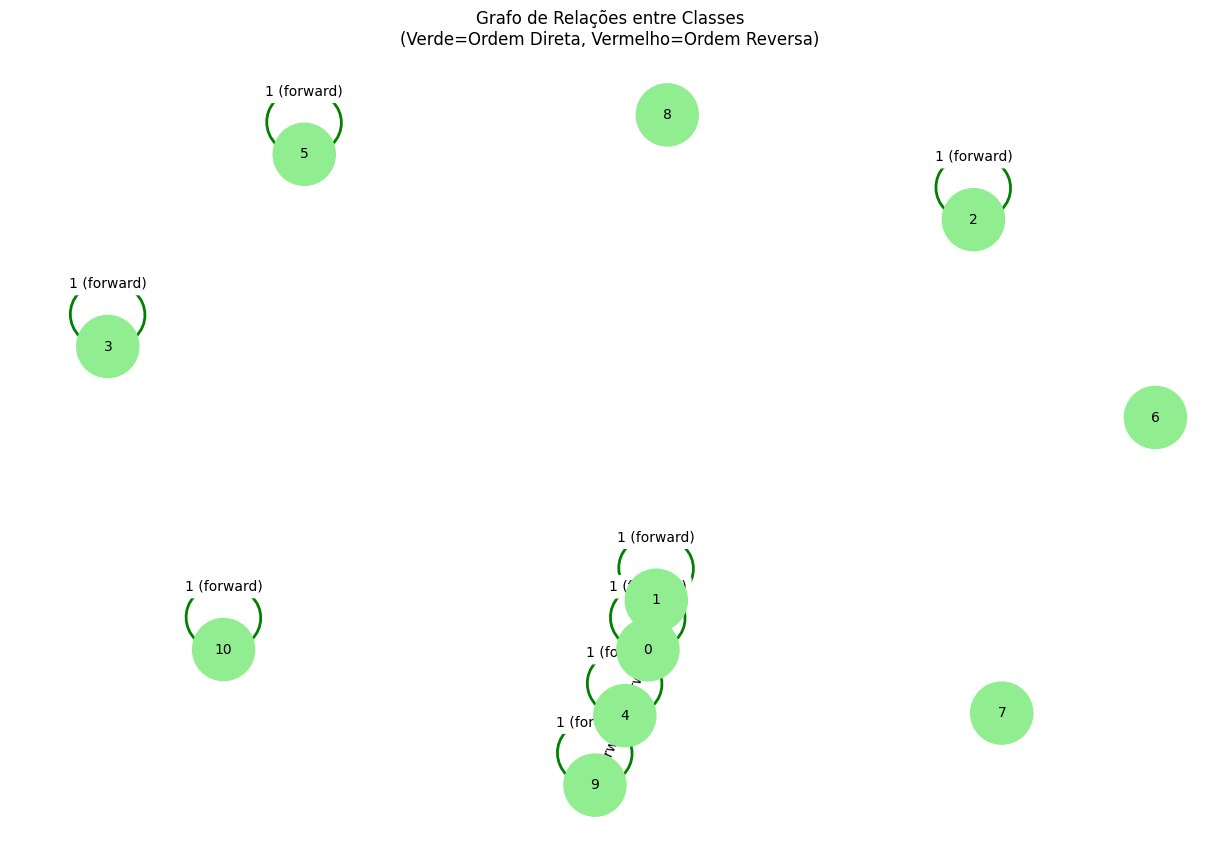


4. Tentando ordenação topológica:
  - Ciclo detectado! Usando método alternativo...

5. Força das classes (quanto maior, mais para o final):
  - Classe 0: 0
  - Classe 1: -1
  - Classe 10: 0
  - Classe 2: 0
  - Classe 3: 0
  - Classe 4: 0
  - Classe 5: 0
  - Classe 6: 0
  - Classe 7: 0
  - Classe 8: 0
  - Classe 9: 1

6. Ordem final baseada em força: 1 → 8 → 6 → 0 → 3 → 2 → 5 → 10 → 4 → 7 → 9

=== RESUMO FINAL ===
Ordem das classes: 1 → 8 → 6 → 0 → 3 → 2 → 5 → 10 → 4 → 7 → 9


In [430]:
def sequenciar_classes_com_debug(df_noesy, visualizar_grafo=True):
    print("=== INÍCIO DA ANÁLISE ===")

    # Etapa 1: Coletar dados
    classes = set()
    conexoes = []

    print("\n1. Identificando conexões entre classes:")
    for idx, row in df_noesy.iterrows():
        if pd.notna(row['AssignF1']) and pd.notna(row['AssignF2']):
            try:
                c1, r1, a1 = row['AssignF1'].split('_')
                c2, r2, a2 = row['AssignF2'].split('_')

                classes.add(c1)
                classes.add(c2)

                conexao = {
                    'tipo': f"{a2}-{a1}",
                    'de': c2,
                    'para': c1,
                    'evidencia': f"Linha {idx}: {row['AssignF2']} → {row['AssignF1']}"
                }
                conexoes.append(conexao)

                print(f"  - {conexao['evidencia']} (Tipo: {conexao['tipo']})")
            except:
                continue

    # Etapa 2: Construir grafo de relações
    G = nx.DiGraph()
    G.add_nodes_from(classes)

    regras = {
        'HN-HN': "Classe F2 deve vir ANTES de F1 (peso -1)",
        'HN-HA': "Classe F1 deve vir ANTES de F2 (peso +1)",
        'HA-HN': "Ignorada (não considerada na ordenação)",
        'HA-HA': "Ignorada (não considerada na ordenação)"
    }

    print("\n2. Regras de interpretação:")
    for tipo, desc in regras.items():
        print(f"  - {tipo}: {desc}")

    print("\n3. Aplicando regras às conexões:")
    edge_weights = defaultdict(int)
    for c in conexoes:
        if c['tipo'] == 'HN-HN':
            edge_weights[(c['de'], c['para'])] -= 1
            print(f"  - {c['evidencia']} → {c['de']} antes de {c['para']} (HN-HN)")
        elif c['tipo'] == 'HN-HA':
            edge_weights[(c['para'], c['de'])] += 1
            print(f"  - {c['evidencia']} → {c['para']} antes de {c['de']} (HN-HA)")

    # Adicionar arestas ao grafo
    for (u, v), weight in edge_weights.items():
        if weight != 0:
            direction = 'forward' if weight > 0 else 'reverse'
            G.add_edge(u, v, weight=abs(weight), direction=direction)

    # Etapa 3: Visualização do grafo
    if visualizar_grafo and G.number_of_edges() > 0:
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G, seed=42)

        # Configurações de visualização
        node_colors = ['lightgreen' if n in classes else 'lightgray' for n in G.nodes()]
        edge_colors = ['red' if d['direction'] == 'reverse' else 'green' for u, v, d in G.edges(data=True)]

        nx.draw(G, pos, with_labels=True, node_size=2000,
                node_color=node_colors, font_size=10,
                edge_color=edge_colors, width=2, arrowsize=20)

        edge_labels = {(u, v): f"{d['weight']} ({d['direction']})" for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.title("Grafo de Relações entre Classes\n(Verde=Ordem Direta, Vermelho=Ordem Reversa)")
        plt.show()

    # Etapa 4: Ordenação topológica
    print("\n4. Tentando ordenação topológica:")
    try:
        ordem = list(nx.topological_sort(G))
        print("  - Ordem encontrada:", " → ".join(ordem))
    except nx.NetworkXUnfeasible:
        print("  - Ciclo detectado! Usando método alternativo...")

        # Calcular "força" de cada nó
        node_strength = defaultdict(int)
        for u, v, d in G.edges(data=True):
            if d['direction'] == 'forward':
                node_strength[v] += d['weight']
                node_strength[u] -= d['weight']
            else:
                node_strength[u] += d['weight']
                node_strength[v] -= d['weight']

        print("\n5. Força das classes (quanto maior, mais para o final):")
        for classe in sorted(classes):
            print(f"  - Classe {classe}: {node_strength.get(classe, 0)}")

        ordem = sorted(classes, key=lambda x: node_strength.get(x, 0))
        print("\n6. Ordem final baseada em força:", " → ".join(ordem))

    print("\n=== RESUMO FINAL ===")
    print("Ordem das classes:", " → ".join(ordem))
    return ordem

# Uso:
ordem_final = sequenciar_classes_com_debug(df_noesy)